## Deforestation Impact

The deforestation (or land use change) due to commodity driven agriculture is a useful measure of the impact a comapnys supply chain has on nature.

Here we attempt to measure the likelihood that deforestation in an area is due to the presence of some commodity production, as well as the impact on the quality of forest as a result.

A supply chain should aim to minimise the amount of deforestation as a result of it's presence, as per SDG targets 15.1 and 15.2.


Potential datasets:

- 

### Import libraries:

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
import time
from rasterstats import gen_zonal_stats, gen_point_query
from shapely.geometry import shape, mapping
import folium
from rasterstats import gen_zonal_stats, gen_point_query
import h3
import os

/Users/vizzuality/anaconda3/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from processing.geolocating_data import GeolocateAddress

## Inspect Satelligence Data
 
 
As per SDG 15.1 and 15.2 - we are interested in:

- 15.1.1 - Forest Area as a proportion of Land.
- 15.2.1 - Progress towards sustainable forest management

We should extract the % area cover of forest in the region, as well as change.


In [3]:
input_path = '../../datasets/raw/satelligence_sample_data'

os.listdir(input_path)

['change_detection',
 '.DS_Store',
 'IND_Riau_outline.prj',
 'forest_and_plantation_baseline',
 'carbonstock',
 'IDN_Riau_outline.geojson',
 'IND_Riau_outline.shx',
 'IND_Riau_outline.shp',
 'IND_Riau_outline.cpg',
 'IND_Riau_outline.dbf',
 'IDN_Riau_Baseline_2019']

In [4]:
baseline_path =  input_path + '/forest_and_plantation_baseline'
change_path =  input_path + '/change_detection'

In [5]:
# Baseline Forest

files = [f"/{f}" for f in os.listdir(baseline_path) if '.tif' in f]
files

['/IDN_Riau_Forest_and_plantation_baseline_20180101.tif.aux.xml',
 '/IDN_Riau_Forest_and_plantation_baseline_20180101.tif',
 '/IDN_Riau_baseline_2019.tif']

In [6]:
file = baseline_path + files[1]

#explore datasets info for calculation - the three raster need to have the same extent and projection
baseline_info = !gdalinfo $file
baseline_info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/raw/satelligence_sample_data/forest_and_plantation_baseline/IDN_Riau_Forest_and_plantation_baseline_20180101.tif',
 '       ../../datasets/raw/satelligence_sample_data/forest_and_plantation_baseline/IDN_Riau_Forest_and_plantation_baseline_20180101.tif.aux.xml',
 'Size is 14063, 14995',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (100.024529999999999,2.918900000000000)',
 'Pixel Size 

In [7]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#ffffff','#9bff8f','#73a367'])

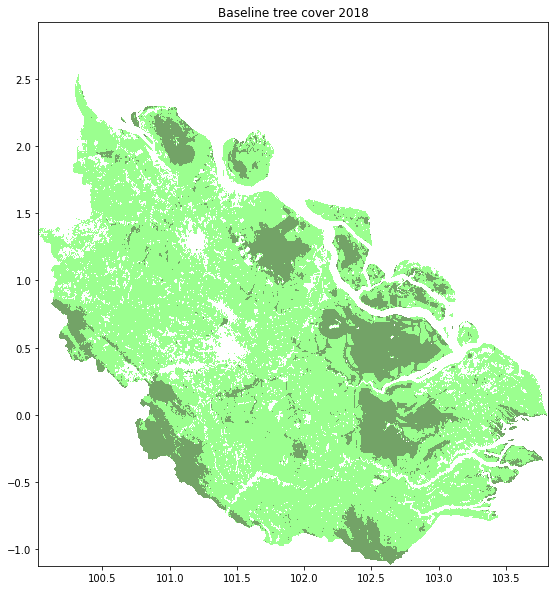

In [8]:
#check 2018 baseline

# Legend
# 0 Non forest  
# 1 Forest
# 2 Primary Forest

with rio.open(file) as src:
    image_array = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=2, cmap=custom_cmap, ax=ax, transform=src.transform)
    ax.set_title('Baseline tree cover 2018')
    
    

In [9]:
file = baseline_path + files[2]

#explore datasets info for calculation - the three raster need to have the same extent and projection
baseline_info = !gdalinfo $file
baseline_info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/raw/satelligence_sample_data/forest_and_plantation_baseline/IDN_Riau_baseline_2019.tif',
 'Size is 63007, 42602',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (99.140950000000004,2.593080000000000)',
 'Pixel Size = (0.000089831447300,-0.000089831463312)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  TIFFTAG_SOFTWARE=GRASS GIS 7.8.5 with GDAL 3.2.1',
 'Image Structure Metadata:',
 '  COM

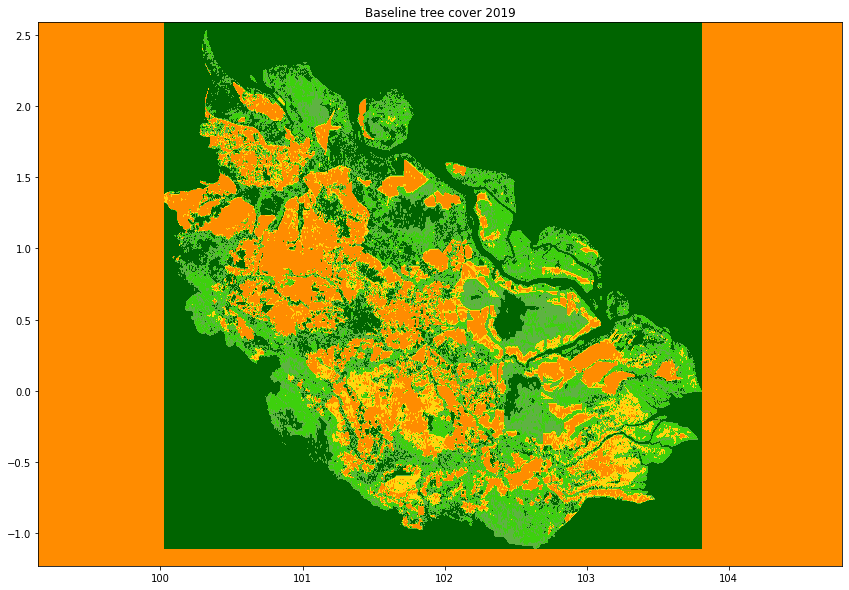

In [10]:
#check calculated risk map

custom_cmap = ListedColormap(["darkgreen","#5eb342","#3dd00d","#ffd60e","darkorange"])

# Legend
# 1 Primary Forest
# 2 Logged over Forest
# 3 Degraded or regenerating Forest
# 4 Other plantations
# 5 Palm oil plantations

with rio.open(file) as src:
    image_array = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=5, cmap=custom_cmap, ax=ax, transform=src.transform)
    ax.set_title('Baseline tree cover 2019')
    
    

In [11]:
# Forest change

files = [f"/{f}" for f in os.listdir(change_path) if '.tif' in f]
files

['/IDN_Riau_ChangeDetection_ForestAndPlantations.tif']

In [12]:
file = change_path + files[0]

#explore datasets info for calculation - the three raster need to have the same extent and projection
change_info = !gdalinfo $file
change_info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/raw/satelligence_sample_data/change_detection/IDN_Riau_ChangeDetection_ForestAndPlantations.tif',
 'Size is 14063, 14995',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (100.024529999999999,2.918900000000000)',
 'Pixel Size = (0.000269494417976,-0.000269495165055)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image Structure Metadata:',
 '  COMPRESSION=DEFLATE',
 '  INTERLEAVE=BAND',
 '  

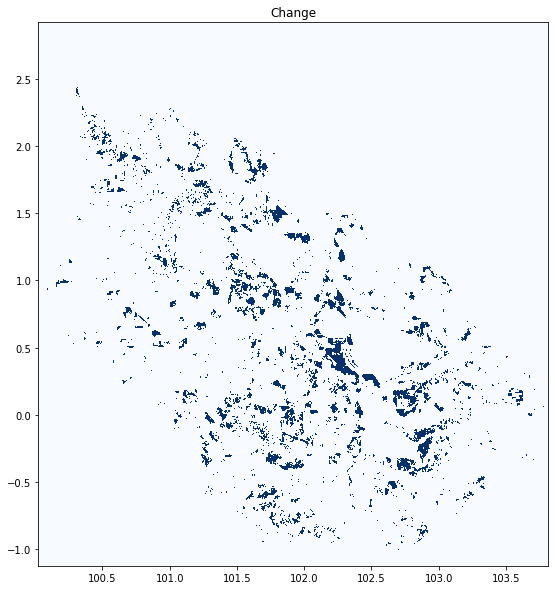

In [13]:
#check calculated risk map

# Values in format YYYY-jjj e.g. 2019074 where jjj = julian day from 1-366

with rio.open(file) as src:
    image_array = src.read(1)
    meta = src.meta
    profile = src.profile
    
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=5, cmap='Blues', ax=ax, transform=src.transform)
    ax.set_title('Change')
    
    

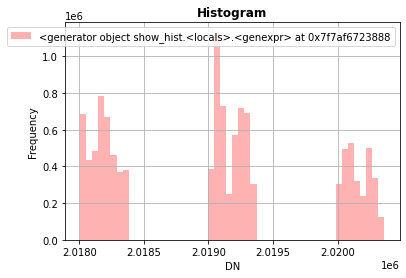

In [14]:
src = rio.open(file)
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

In [15]:
image_array.shape

(14995, 14063)

In [16]:
## Set values to year
loss2018_array = image_array.copy()

loss2018_array[(loss2018_array >= 2018000) & (loss2018_array < 2019000)] = 1
loss2018_array[loss2018_array >= 2019000] = 0

Text(0.5, 1.0, 'Change')

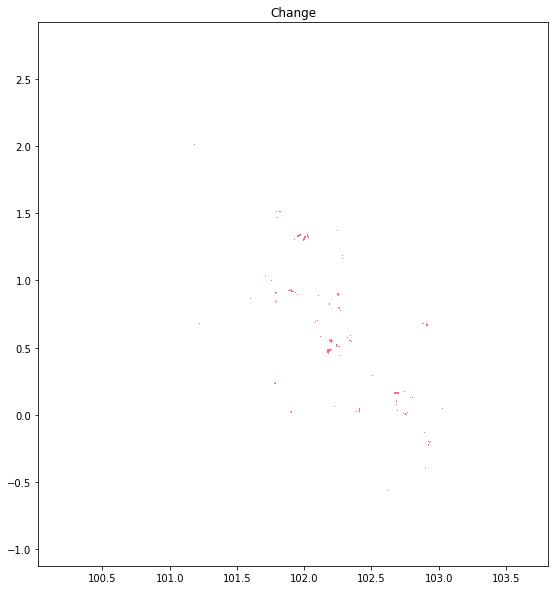

In [17]:
custom_cmap = ListedColormap(["white", "#f69"])

fig, ax = plt.subplots(figsize=[15,10])
rio.plot.show(loss2018_array, vmin=0, vmax=1, cmap=custom_cmap, ax=ax, transform=src.transform)
ax.set_title('Change')

In [18]:
output_path = '../../datasets/processed/'

os.listdir(input_path)

['change_detection',
 '.DS_Store',
 'IND_Riau_outline.prj',
 'forest_and_plantation_baseline',
 'carbonstock',
 'IDN_Riau_outline.geojson',
 'IND_Riau_outline.shx',
 'IND_Riau_outline.shp',
 'IND_Riau_outline.cpg',
 'IND_Riau_outline.dbf',
 'IDN_Riau_Baseline_2019']

In [19]:
meta

{'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 14995,
 'nodata': -3.4028234663852886e+38,
 'transform': Affine(0.0002694944179762499, 0.0, 100.02453,
       0.0, -0.00026949516505501834, 2.9189),
 'width': 14063}

In [20]:
## Save as rio dataset
defor_path = output_path + 'sat_loss_2018.tif'
with rasterio.open(defor_path, "w", **profile) as dest:
    dest.write(loss2018_array, 1)
    
loss2018_array = None

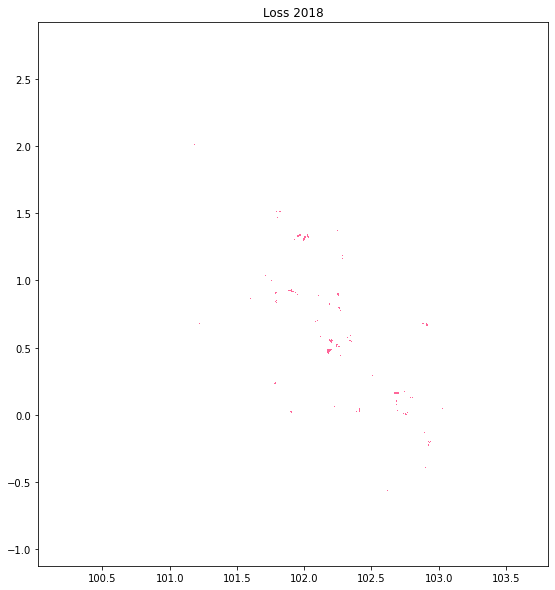

In [21]:
# open again

custom_cmap = ListedColormap(["white", "#f69"])

with rio.open(defor_path) as src:
    image_array = src.read(1)
    meta = src.meta
    profile = src.profile
    
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=1, cmap=custom_cmap, ax=ax, transform=src.transform)
    ax.set_title('Loss 2018')
    
    

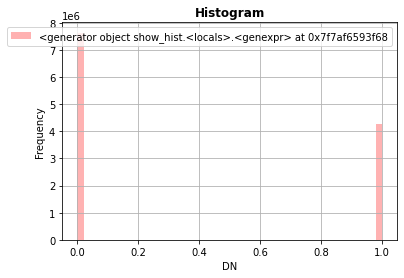

In [22]:
src = rio.open(defor_path)
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

In [23]:
## Dump cache
image_array = None

### Calculation of Commodity-driven Deforestation Risk (risk map)

Using the Harvested Area fraction (f) from Earthstat, Deforestation Risk (Dr) is the binary Deforestation pixels (D) multiplied by the Harvested Area fraction (f), and gives a naive likelihood that the deforestation event is a result of the commodity. 

`Dr = f.D`

This is indipendent of yeild or volume and gives a general indication of deforesation risk.

In [24]:
ha_fraction_path = '../../datasets/raw/cotton_HarvestedAreaFraction.tif'

In [25]:
info = !gdalinfo $defor_path
info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/processed/sat_loss_2018.tif',
 'Size is 14063, 14995',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (100.024529999999999,2.918900000000000)',
 'Pixel Size = (0.000269494417976,-0.000269495165055)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image Structure Metadata:',
 '  COMPRESSION=DEFLATE',
 '  INTERLEAVE=BAND',
 'Corner Coordinates:',
 'Upper Left  ( 100.0245300,   2.9189000) (100d 

In [26]:
## projwin: upper left and lower right of the raster that we want to use for clipping the other rasters
# e.g. !gdal_translate -projwin <ul_lat> <ul_lon> <lr_lat>  <lr_lon>

## -of GTiff: geotiff we want to clip - change extent
# e.g. -of GTiff <input> <output>

clipped_output = '../../datasets/processed/cotton_HarvestedAreaFraction_clipped.tif'

!gdal_translate -projwin 100.0245300 2.9189000 103.8144300 -1.1221800 -of GTiff $ha_fraction_path $clipped_output

Input file size is 4320, 2160
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
0...10...20...30...40...50...60...70...80...90...100 - done.


In [27]:
info = !gdalinfo $clipped_output
info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/processed/cotton_HarvestedAreaFraction_clipped.tif',
 'Size is 45, 48',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (99.999999999984084,2.999999999994714)',
 'Pixel Size = (0.083333333333329,-0.083333333333329)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6',
 'Image Structure Metadata:',
 '  INTERLEAVE=BAND',
 'Corner Coordinates:',
 'U

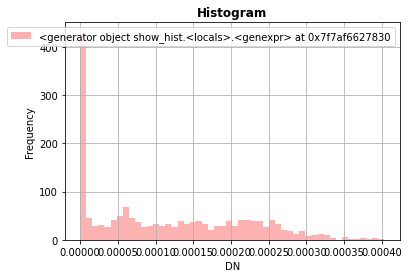

In [28]:
src = rio.open(clipped_output)
show_hist(
    src,
    bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")


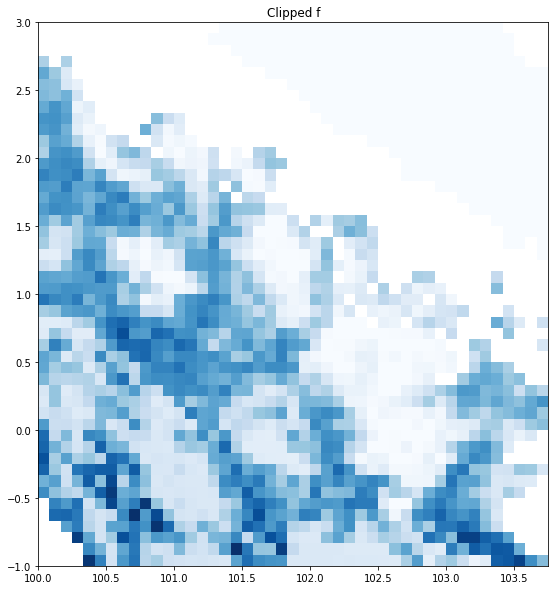

In [81]:
with rio.open(clipped_output) as src:
    image_array = src.read(1)
    meta = src.meta
    profile = src.profile
    
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=4e-4, cmap='Blues', ax=ax, transform=src.transform)
    ax.set_title('Clipped f')

In [85]:
## Inspect total area fraction
sum(image_array[~np.isnan(image_array)])

0.19197920776917954

In [30]:
## Resample and multiply

In [91]:
resampled_output = '../../datasets/processed/cotton_HarvestedAreaFraction_resampled_30m.tif'
!gdalwarp -tr 0.000269494417976 0.000269495165055 -r near -of GTiff $clipped_output $resampled_output

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
Creating output file that is 13915P x 14843L.
Processing ../../datasets/processed/cotton_HarvestedAreaFraction_clipped.tif [1/1] : 0..ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
.10...20...30...40...50...60...70...80...90...100 - done.


In [92]:
info = !gdalinfo $resampled_output
info

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/processed/cotton_HarvestedAreaFraction_resampled_30m.tif',
 'Size is 13915, 14843',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["latitude",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["longitude",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (99.999999999984084,2.999999999994714)',
 'Pixel Size = (0.000269494417976,-0.000269495165055)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  TIFFTAG_SOFTWARE=MATLAB 8.0, Mapping Toolbox 3.6',
 'Image Structure Metadata:',
 '  INTERLEAVE=BAND',
 'Corner Coordi

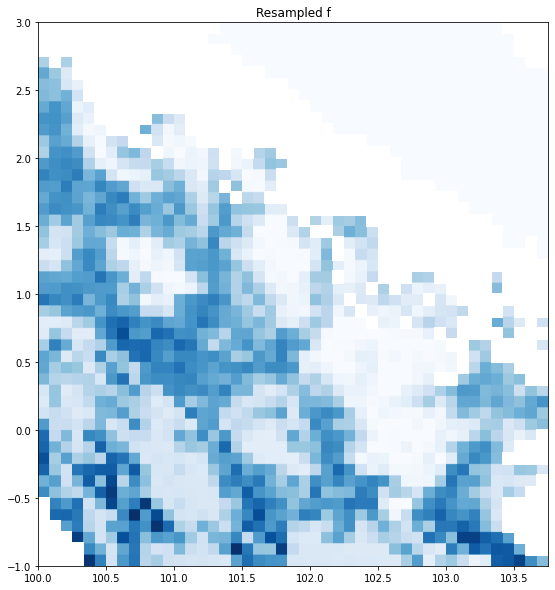

In [93]:
with rio.open(resampled_output) as src:
    image_array = src.read(1)
    meta = src.meta
    profile = src.profile
    
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=4e-4, cmap='Blues', ax=ax, transform=src.transform)
    ax.set_title('Resampled f')

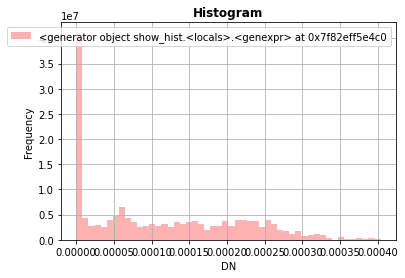

In [94]:
src = rio.open(resampled_output)
show_hist(
    src,
    bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")


In [95]:
## Inspect total resampled area fraction
sum(image_array[~np.isnan(image_array)])

18357.141913586125

In [123]:
## Had to clip both to match

defor_clipped_output = '../../datasets/processed/defor_clipped.tif'
reclipped_output = '../../datasets/processed/cotton_HarvestedAreaFraction_resampled_clipped.tif'

!gdal_translate -projwin 100.0245300 2.9189000 103.8144300 -1.1221800 -of GTiff $defor_path $defor_clipped_output
!gdal_translate -projwin 100.0245300 2.9189000 103.8144300 -1.1221800 -of GTiff $resampled_output $reclipped_output

Input file size is 14063, 14995
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 13915, 14843
Warning 1: Computed -srcwin 91 300 14063 14995 falls partially outside raster extent. Going on however.
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
## Now generate area raster

In [55]:
input_path = '../../datasets/raw/satelligence_sample_data'

os.listdir(input_path)

['change_detection',
 '.DS_Store',
 'IND_Riau_outline.prj',
 'forest_and_plantation_baseline',
 'carbonstock',
 'IDN_Riau_outline.geojson',
 'IND_Riau_outline.shx',
 'IND_Riau_outline.shp',
 'IND_Riau_outline.cpg',
 'IND_Riau_outline.dbf',
 'IDN_Riau_Baseline_2019']

In [97]:
aoi_path = input_path + '/IND_Riau_outline.shp'

In [56]:
df = gpd.read_file(aoi_path)
df

fid GID_0     NAME_0     GID_1 NAME_1 VARNAME_1 NL_NAME_1     TYPE_1  \
0   24   IDN  Indonesia  IDN.24_1   Riau      None      None  Propinisi   

  ENGTYPE_1 CC_1 HASC_1                                           geometry  
0  Province   14  ID.RI  MULTIPOLYGON (((103.41634 -0.67546, 103.41668 ...

In [99]:
area_path = '../../datasets/processed/idn_pixel_area.tif'

## Naive assumption that all pixels are constant area (ignore proj for now)
pixel_area = 30*30*1e-4
pixel_area

0.09000000000000001

In [106]:
##Create area raster 
!gdal_rasterize -l IND_Riau_outline -burn $pixel_area -tr 0.000269494417976 0.000269495165055 -a_nodata 0.0 -te 100.0245300 -1.1221800 103.8144300 2.9189000 -ot Float32 -of GTiff $aoi_path $area_path


ERROR 1: PROJ: proj_identify: Cannot find proj.db
0...10...20...30...40...50...60...70...80...90...100 - done.


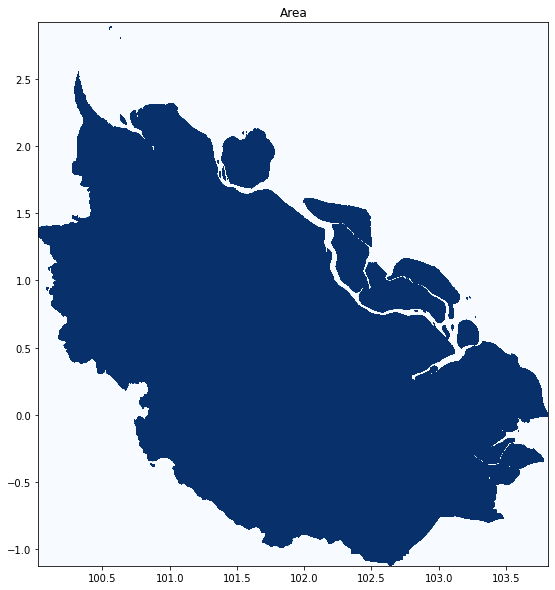

In [108]:
with rio.open(area_path) as src:
    image_array = src.read(1)
    meta = src.meta
    profile = src.profile
    
    fig, ax = plt.subplots(figsize=[15,10])
    rio.plot.show(image_array, vmin=0, vmax=4e-4, cmap='Blues', ax=ax, transform=src.transform)
    ax.set_title('Area')

In [125]:
with rio.open(defor_clipped_output) as src:
    hf_array = src.read(1)
    meta1 = src.meta
    profile1 = src.profile
    
with rio.open(reclipped_output) as src:
    defor_array = src.read(1)
    meta2 = src.meta
    profile2 = src.profile
    
with rio.open(area_path) as src:
    area_array = src.read(1)
    meta3 = src.meta
    profile3 = src.profile

In [126]:
defor_array[np.isnan(defor_array)] = 0
defor_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [127]:
hf_array[hf_array < 0] = 0
hf_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [128]:
## Multiply boolean deforrestaton by harvest factor
risk_array_unitless = np.multiply(defor_array, hf_array)
risk_array = np.multiply(area_array, risk_array_unitless)

Text(0.5, 1.0, 'Risk')

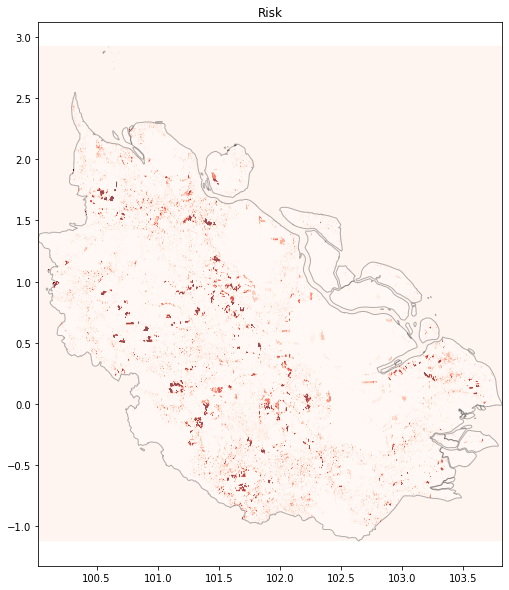

In [133]:
fig, ax = plt.subplots(figsize=[15,10])
rio.plot.show(risk_array, vmin=0, vmax=1e-5, cmap='Reds', ax=ax, transform=src.transform)
df.plot(ax=ax, alpha=0.3, color='#ffffff', edgecolor='black')
ax.set_title('Risk')

In [130]:
## Inspect total area fraction
sum(sum(risk_array))

41.4868094894407

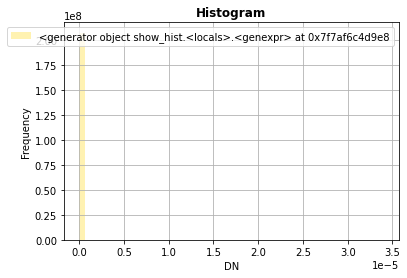

In [131]:
show_hist(
    risk_array, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")


In [134]:
## Save as rio dataset

with rasterio.open(output_path + 'deforestation_risk_ha_2018.tif', "w", **profile2) as dest:
    dest.write(risk_array, 1)
    
risk_array = None

### 1. Check raster info:

### 2. Extent: Calculation of Commodity-driven Deforestation Risk Metric inside location.

Using the Assignation Function (f') of each pixel:

`f' = V/At * f/y`

- V = Volume of commodity Purchased (const)
- f = Area Fraction used to produce commodity (per pixel)
- At = Total area used to produce ALL of the commodity (const)
    - where At = `a*sum(f)` i.e. integrated pixel area * f
- a = pixel area
- y = Commodity yield (per pixel)

We then have a measure of the likelihood that the purchased commoity was sources inside a given pixel (0-1). 

From there we need to locate deforestation pixels and associate them with commodity pixels

Then, `Ap = sum(a*f')`

In [ ]:
## Calculate AT (const)
# sum(pixel area * harvest fraction) over all pixels

## Generate f/y (raster)

## Generate V/At (raster) 

## Generate f' (raster) = V/At * f/y

In [109]:
# generate h3 for india file
def generate_h3_features(geometry, res):
    """
    Generate h3 for geometry
    
    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon
    
    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id'])
    if geometry.geom_type == 'MultiPolygon':
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
                yield {
                    "type": "Feature",
                    "properties": {"hexid": h3_hex},
                    "geometry": {"type": "Polygon", "coordinates": coords[0]},
                }
    elif geometry.geom_type == 'Polygon':
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson['features'][0]['geometry']
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
            yield {
                "type": "Feature",
                "properties": {"hexid": h3_hex},
                "geometry": {"type": "Polygon", "coordinates": coords[0]},
            }
    else:
        print('Shape is not a polygon or multypolygon.')


In [110]:
#time spend in generating the features in h3 for the basins test in resolution 1
start_time = time.time()
h3_idn_res6 = [generate_h3_features(poly, 6) for poly in df['geometry']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0542600154876709 seconds ---


In [117]:
## zonal statistics with harvest area protion to calculate distribution 
#summary statistics world main basins
start_time = time.time()

summ_stats_h3_idn = [gen_zonal_stats(
    generator,
    risk_path,
    stats="sum",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_idn_res6]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0001480579376220703 seconds ---


In [119]:
## generate datafram
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_idn_res6 = pd.DataFrame([],columns=['h3_id', 'area_fraction'])
for generator in summ_stats_h3_idn:
    for feature in generator:
        h3_gdf_idn_res6.loc[len(h3_gdf_idn_res6)]=[
            feature['properties']['hexid'],
            feature['properties']['m_sum']]
print("--- %s seconds ---" % (time.time() - start_time))

/Users/vizzuality/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


--- 40.28767204284668 seconds ---


In [135]:
#remove nans
h3_gdf_idn_res6['Volume'] = 25
h3_gdf_idn_res6 = h3_gdf_idn_res6.dropna()
h3_gdf_idn_res6['total_af'] = sum(list(h3_gdf_idn_res6['area_fraction']))
h3_gdf_idn_res6.head()

h3_id  area_fraction  Volume    total_af  assignation_factor  \
0  868c8b317ffffff       0.008155      25  461.916301        1.765526e-05   
1  868c8b3afffffff       0.012579      25  461.916301        2.723182e-05   
2  868c8b68fffffff       0.000120      25  461.916301        2.607805e-07   
3  868c8b687ffffff       0.000165      25  461.916301        3.567624e-07   
4  868cd31b7ffffff       0.003624      25  461.916301        7.846603e-06   

   distributed_vol  
0         0.000441  
1         0.000681  
2         0.000007  
3         0.000009  
4         0.000196

In [121]:
## calculate asignation fraction as area fraction / total_af
for i, row in h3_gdf_idn_res6.iterrows():
    assignation_factor = row['area_fraction']/ row['total_af']
    distributed_volume = row['Volume']*assignation_factor
    h3_gdf_idn_res6.loc[i, 'assignation_factor'] = assignation_factor
    h3_gdf_idn_res6.loc[i, 'distributed_vol'] = distributed_volume

h3_gdf_idn_res6.head()

h3_id  area_fraction  Volume    total_af  assignation_factor  \
0  868c8b317ffffff       0.008155      25  461.916301        1.765526e-05   
1  868c8b3afffffff       0.012579      25  461.916301        2.723182e-05   
2  868c8b68fffffff       0.000120      25  461.916301        2.607805e-07   
3  868c8b687ffffff       0.000165      25  461.916301        3.567624e-07   
4  868cd31b7ffffff       0.003624      25  461.916301        7.846603e-06   

   distributed_vol  
0         0.000441  
1         0.000681  
2         0.000007  
3         0.000009  
4         0.000196

### 3. Calculate risk 

In [ ]:
cotton_DataQuality_Yield.tif

### 4. Explore output:

### 4. Reproject raster from epsg:4326 to epsg:3857

Reproject raster from 4326 to 3857 as the hexgrid is in that projection. We can do it the other way around by reprojecting the vector layer from epsg:3857 to epsg:4326.